In [8]:
# IMPORT LIBRARIES AND NOISE DATA FILE
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import timeit
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
from theano.tensor.signal.pool import pool_2d
from sknn.mlp import Regressor, Layer
from sklearn.preprocessing import StandardScaler 
from scipy import stats; from sklearn import preprocessing
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from timeit import default_timer as timer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

#################################################################
noisefile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\2017-07-19 s-swcnt 7c noise h2o.txt' #CorrEl NOISE filename
sdline1, sdline2 = 14, 99 #lines to start and stop import of standard deviation data
#################################################################
sddata = pd.read_table(noisefile, skiprows=sdline1, error_bad_lines=False, sep='\s+') #read in file
sddata = sddata[:sdline2].apply(pd.to_numeric, errors='coerce') #str to flt, coerce to NaN, and erase past st. dev. data
print(sddata)

C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
b'Skipping line 6452: expected 6 fields, saw 7\n'
C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on im

       time       /             s  volt.noise/V  curr.noise/A  pow.noise/W
0       0.0  0.0193  1.150000e-09  3.070000e-12           NaN          NaN
1    1000.0  0.0191  1.120000e-09  2.910000e-12           NaN          NaN
2    2000.0  0.0193  1.110000e-09  2.660000e-12           NaN          NaN
3    3000.0  0.0192  1.100000e-09  2.910000e-12           NaN          NaN
4    4000.0  0.0192  1.090000e-09  3.010000e-12           NaN          NaN
5    5000.0  0.0191  1.100000e-09  3.080000e-12           NaN          NaN
6    6000.0  0.0192  1.130000e-09  2.940000e-12           NaN          NaN
7    7000.0  0.0190  1.120000e-09  2.880000e-12           NaN          NaN
8    8000.0  0.0190  1.090000e-09  2.680000e-12           NaN          NaN
9    9000.0  0.0191  1.190000e-09  2.710000e-12           NaN          NaN
10  10000.0  0.0191  1.130000e-09  3.050000e-12           NaN          NaN
11  11000.0  0.0191  1.110000e-09  2.790000e-12           NaN          NaN
12  12000.0  0.0189  1.09

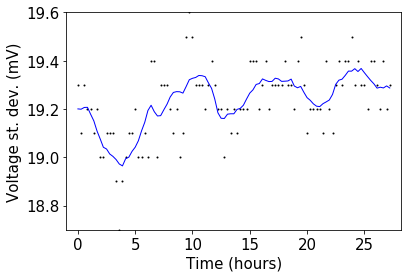

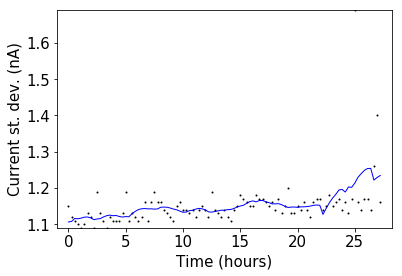

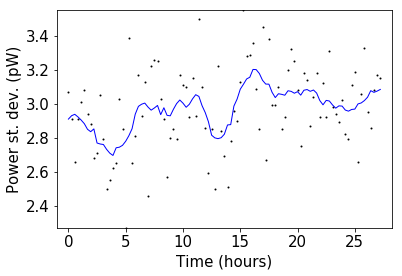

In [9]:
# ORGANIZE AND PLOT STANDARD DEVIATION VS. TIME DATA FROM NOISE FILE
sdtime = np.array(sddata['time'])/3600
sdv = np.array(sddata['/'])*1e3 #voltage in mVolts
sdi = np.array(sddata['s'])*1e9 #current in nanoAmps
sdp = np.array(sddata['volt.noise/V'])*1e12 #power in pWatts

sdvars = [sdv, sdi, sdp] #list for sd plotting
sdlabels = ['Voltage st. dev. (mV)', 'Current st. dev. (nA)', 'Power st. dev. (pW)'] #list for y labels of plots
for i in range(len(sdvars)):
    #filter data for smoothing
    sdfilt = savgol_filter(sdvars[i], 21, 2, mode='mirror') #points, polynomial order, bound. cond.
    plt.plot(sdtime, sdfilt, color='b', linewidth=1) #plot filtered data
    plt.scatter(sdtime, sdvars[i], s=1, color='k') #plot raw sd data
    plt.xlabel('Time (hours)', fontsize=15); plt.ylabel(sdlabels[i], fontsize=15)
    plt.axis((min(sdtime)-1, max(sdtime)+1, min(sdvars[i]), max(sdvars[i])))
    plt.show()

In [10]:
# EXTRACT FREQUENCY DATA FROM NOISE FILE #############################################################
fline1 = sdline2 + 17 #lines to start and stop import of frequency data

#####################################################################################################
fdata0 = pd.read_table(noisefile, skiprows=fline1, header=0, error_bad_lines=False, sep='\s+') #read in file
fdata = fdata0.apply(pd.to_numeric, errors='coerce').dropna() #change from string to float, coercing to NaN 
print(fdata)

b'Skipping line 6452: expected 4 fields, saw 7\n'
C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


      Frequency/Hz  volt.noise/V  curr.noise/A   pow.noise/W
0           0.0000      0.002850  2.600000e-08  7.420000e-11
1           0.0005      0.002850  2.600000e-08  7.420000e-11
2           0.0010      0.000030  1.300000e-10  3.940000e-15
3           0.0015      0.000056  1.360000e-10  7.590000e-15
4           0.0020      0.000074  7.380000e-11  5.440000e-15
5           0.0025      0.000044  7.180000e-11  3.130000e-15
6           0.0030      0.000013  6.000000e-11  8.010000e-16
7           0.0035      0.000031  7.940000e-11  2.500000e-15
8           0.0040      0.000064  9.180000e-11  5.920000e-15
9           0.0045      0.000037  9.910000e-12  3.680000e-16
10          0.0050      0.000030  3.600000e-11  1.100000e-15
11          0.0055      0.000020  5.260000e-11  1.030000e-15
12          0.0060      0.000028  1.130000e-10  3.200000e-15
13          0.0065      0.000006  1.690000e-11  1.010000e-16
14          0.0070      0.000027  5.460000e-11  1.480000e-15
15          0.0075      

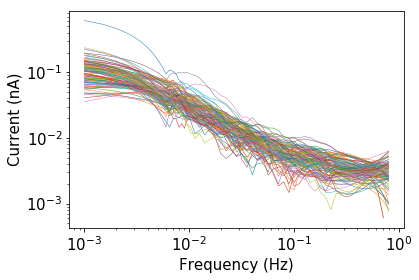

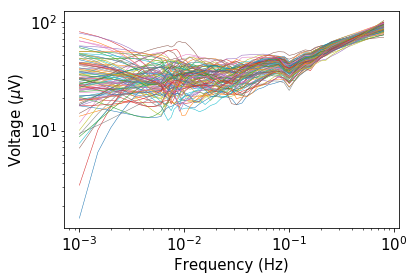

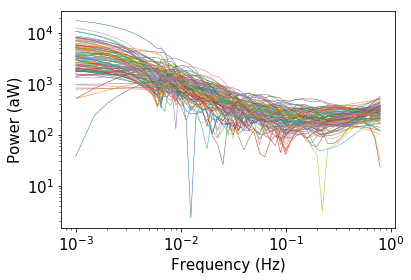

In [11]:
# PLOT FREQUENCY DOMAIN DATA
allf = np.array(fdata['Frequency/Hz']) #frequency in Hz
allv = np.array(fdata['volt.noise/V'])*1e6 #voltage in microVolts
alli = np.array(fdata['curr.noise/A'])*1e9 #current in nanoAmps
allp = np.array(fdata['pow.noise/W'])*1e18 #power in attoWatts

fsweep = []; i=0
while allf[i+1] > allf[i]: fsweep.append(allf[i]); i=i+1 #find length of each freq sweep

fmat0 = np.reshape(allf, (-1,len(fsweep)+1)); imat0 = np.reshape(alli, (-1,len(fsweep)+1)) #reshape into matrices
vmat0 = np.reshape(allv, (-1,len(fsweep)+1)); pmat0 = np.reshape(allp, (-1,len(fsweep)+1))

#set starting/ending indices to remove errant points from freq. measurements############################
si, ei = 2, 2
########################################################################################################
#new empty matrices without first/last couple points
fmat = np.ones((np.shape(fmat0)[0],np.shape(fmat0)[1]-si-ei));
vmat=np.copy(fmat); imat=np.copy(fmat); pmat=np.copy(fmat); zmat=np.copy(fmat)

for i in range(len(fmat)): #create matrices without the first/last couple points
    fmat[i] = fmat0[i][si:-ei]; vmat[i] = vmat0[i][si:-ei]
    imat[i] = imat0[i][si:-ei]; pmat[i] = pmat0[i][si:-ei]
    
fvars = [imat, vmat, pmat] #make lists for looping over plots
flabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)']

for j in range(len(flabels)): #plot filtered freq-dependent noise spectra
    for i in range(len(fmat)): 
        ffilt = savgol_filter(fvars[j][i], 21, 2, mode='interp') #points, polynomial order, bound. cond.
        plt.loglog(fmat[i],ffilt, linewidth=.5) #plot noise
    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(flabels[j],fontsize=15)
    plt.show()

# FIT FREQUENCY DOMAIN DATA fit noise to pink (1/f) or brown (1/f^2)
timecycle = np.arange(len(fmat))*1000/60/60 #create time array

def noisefit(f, c, n):  # define variables in each function
    return c / f**n

for k in range(len(fvars)): #loop over varibles (current, power, impedance)
    clist = []; nlist = [] #save lists of fitting parameters
    for i in range(len(fmat)): #loop over number of timing cycles
        try:
            popt, pcov = curve_fit(noisefit, fmat[i], ffilt)# fvars[k][i]) #find fit parameters
            fit =  noisefit(fmat[i], *popt) #build fit line
            c = popt[0]; n = popt[1] #get fitting parameters from popt
            clist.append(c); nlist.append(n)
        
            plt.semilogy(fmat[i],fvars[k][i]) #plot fits
            plt.plot(fmat[i],fit,linewidth=1, c='k')
        
        except RuntimeError: #if error in fitting, keep going amnd assign 0 values
            clist.append(0); nlist.append(0)
            print('error in fitting column index ' + format(i))

    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(flabels[k],fontsize=15);
    plt.show()

    plt.plot(timecycle,clist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('c : ' + flabels[k],fontsize=15); plt.show()

    plt.plot(timecycle,nlist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('n : ' + flabels[k],fontsize=15); plt.show()


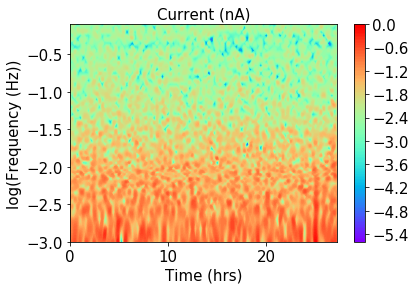

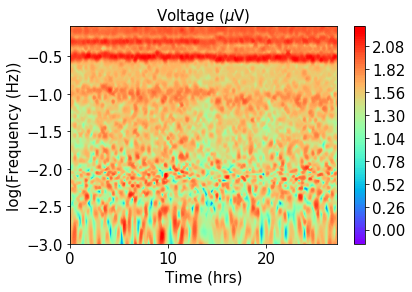

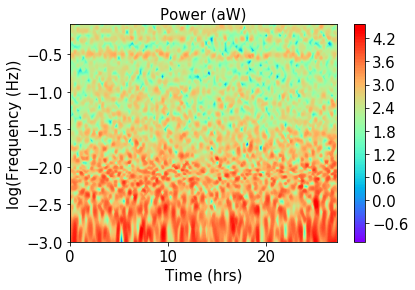

In [12]:
# PLOT IN FREQUENCY DOMAIN OVER TIME
tmatflat = np.array([]) #make flat array of repeating "times"
for i in range(len(fmat)): tmatflat = np.append(tmatflat, np.ones(len(fmat[0]))*i*1000/60/60)

fmatflat = fmat.flatten(); imatflat = imat.flatten()
vmatflat = vmat.flatten(); pmatflat = pmat.flatten()

Zlist = [imatflat, vmatflat, pmatflat] #list of Z values in heatmaps
heatmaplabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)']


for i in range(len(Zlist)):  # plot heatmaps of time/frequency-dependent noise
    # set X, Y, and Z for plot
    X, Y, Z, = tmatflat, np.log10(fmatflat), np.log10(Zlist[i]) #time, frequency, noise

    # create x-y points to be used in heatmap
    xi = np.linspace(X.min(),X.max(),1000)
    yi = np.linspace(Y.min(),Y.max(),1000)
    # Z is a matrix of x-y values
    zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

    # Create the contour plot
    CS = plt.contourf(xi, yi, zi, 150, cmap=plt.cm.rainbow, vmax=np.nanmax(Z), vmin=np.nanmin(Z))
    plt.colorbar(); plt.xlabel('Time (hrs)',fontsize=15); plt.ylabel('log(Frequency (Hz))',fontsize=15);
    plt.title(heatmaplabels[i],fontsize=15); plt.show()

In [13]:
# EXTRACT TIME-DOMAIN DATA ##########################################################################################
tskip = 6452
tdata = pd.read_csv(noisefile, skiprows=tskip, header=0, error_bad_lines=False, sep='\s+') #read in file
####################################################################################################################
tfloatdata = tdata.apply(pd.to_numeric, errors='coerce') #change from string to float, coercing to NaN 
print(tfloatdata)

        volt.noise/V  curr.noise/A
0          -0.006868  3.144220e-08
1          -0.019623  3.006590e-08
2          -0.000566  3.349140e-08
3           0.004607  3.053440e-08
4          -0.024796  3.299860e-08
5           0.012785  3.101480e-08
6          -0.030366  3.136430e-08
7           0.020262  3.227060e-08
8          -0.031052  3.108350e-08
9           0.020065  3.238520e-08
10         -0.018663  3.065030e-08
11         -0.011858  3.380720e-08
12          0.003981  3.102420e-08
13         -0.022873  3.298180e-08
14          0.017776  3.125300e-08
15         -0.029313  3.162990e-08
16          0.018646  3.139170e-08
17         -0.034897  3.087150e-08
18          0.017485  3.257290e-08
19         -0.026474  3.022750e-08
20          0.000380  3.195630e-08
21         -0.005159  2.878880e-08
22         -0.021364  3.316340e-08
23          0.018417  3.269650e-08
24         -0.033861  3.277740e-08
25          0.019682  3.211050e-08
26         -0.031998  3.177470e-08
27          0.012511

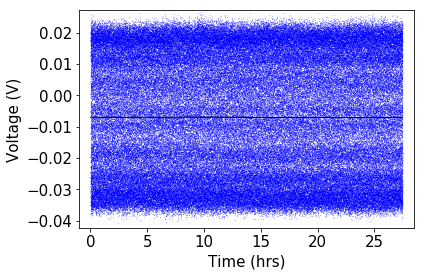

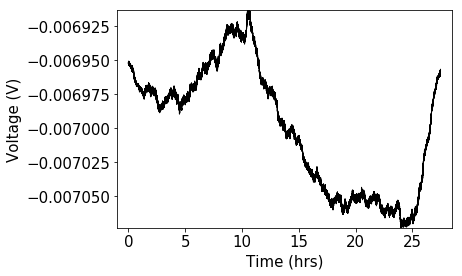

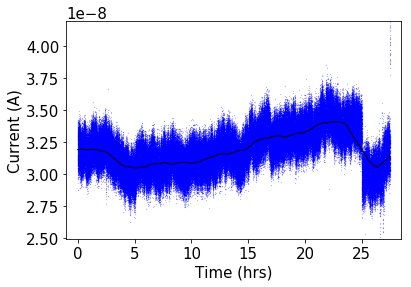

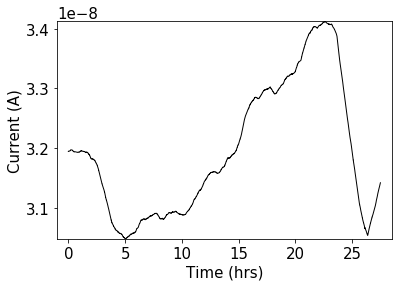

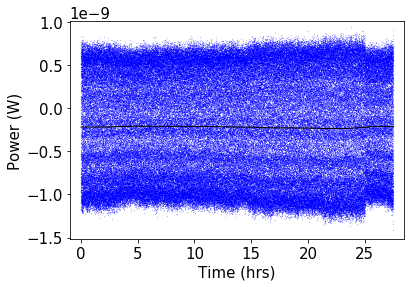

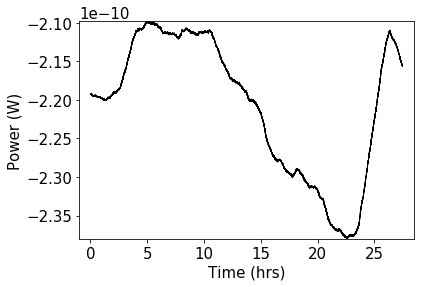

In [14]:
#ORGANIZE AND FILTER/SMOOTH TIME-DOMAIN DATA
from scipy import signal

vt = np.array(tfloatdata['volt.noise/V']) #create voltage nad current arrays for time-domain data 
it = np.array(tfloatdata['curr.noise/A'])
pt = np.multiply(vt,it) #calculate power noise

tlong = (np.arange(len(vt))*0.488)/60/60 #create time array in hours

############### Filter signals to smooth them ####################################
filtwindow = 20001 # number of points to use for filtering
filtorder = 1 #polynomial order ot use for filtering
filtmode = 'constant' #'mirror', 'constant', 'wrap', 'nearest' #mode for dealing with boundary conditions

cval = []; cval_filling = [vt, it, pt]; padpoints = 1000 # number of points to use for pad average
for i in range(len(cval_filling)): #average first and last 100 point values to be constants for padding filter 
    cval.append(np.mean((cval_filling[i][si:si+padpoints]) +
                        np.mean(cval_filling[i][-ei-padpoints:-ei]))/2)

vtfilt = savgol_filter(vt, filtwindow, filtorder, mode=filtmode, cval=cval[0])
itfilt = savgol_filter(it, filtwindow, filtorder, mode=filtmode, cval=cval[1])
ptfilt = savgol_filter(pt, filtwindow, filtorder, mode=filtmode, cval=cval[2])
##################################################################################
tvars = [vt, it, pt, np.divide(vt,it)] #create lists for looping
tfiltvars = [vtfilt, itfilt, ptfilt]
tlabels = ['Voltage (V)', 'Current (A)', 'Power (W)']

for i in range(len(tfiltvars)): #plot noise with smoothed curves
    plt.plot(tlong, tfiltvars[i],linewidth=1, c='k') #plot filtered/smoothed data
    plt.scatter(tlong, tvars[i], s=.01, c='b') #plot raw data
    plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel(tlabels[i], fontsize=15)
    plt.axis((min(tlong)-1,max(tlong)+1,min(tvars[i]), max(tvars[i])))
    plt.show()
    
    plt.plot(tlong, tfiltvars[i],linewidth=1, c='k') #plot ONLY filtered/smoothed data
    plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel(tlabels[i], fontsize=15)
    plt.axis((min(tlong)-1,max(tlong)+1,min(tfiltvars[i]), max(tfiltvars[i])))
    plt.show()

In [15]:
# IMPORT PRESSURE DATA
pressurefile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\2017-07-19 s-swcnt 7c noise under h2o'
pressuredata = pd.read_csv(pressurefile, delimiter = '\t')# skiprows=fline1, header=0, error_bad_lines=False, sep='\s+') #read in file
#fdata = fdata0.apply(pd.to_numeric, errors='coerce').dropna() #change from string to float, coercing to NaN 
print(pressuredata)

                   date_time  elapsed_time_min  J-KEM_temp_C  \
0     2017-07-19 12:30:14.20          0.377088          27.5   
1     2017-07-19 12:30:31.40          0.663738          27.5   
2     2017-07-19 12:30:48.60          0.950354          27.6   
3     2017-07-19 12:31:05.80          1.237071          27.5   
4     2017-07-19 12:31:23.00          1.523787          27.5   
5     2017-07-19 12:31:40.20          1.810470          27.4   
6     2017-07-19 12:31:57.41          2.097153          27.5   
7     2017-07-19 12:32:14.61          2.383836          27.5   
8     2017-07-19 12:32:31.81          2.670519          27.5   
9     2017-07-19 12:32:49.01          2.957269          27.5   
10    2017-07-19 12:33:06.22          3.243986          27.5   
11    2017-07-19 12:33:23.42          3.530702          27.5   
12    2017-07-19 12:33:40.62          3.817385          27.5   
13    2017-07-19 12:33:57.82          4.104101          27.5   
14    2017-07-19 12:34:15.02          4.

[5746 rows x 23 columns]


min/max noise times = 0.0 - 27.484024444444444
min/max pressure times = 0.0 - 27.50213186271667
min/max compressed noise times = 0.0023722222222222217 - 27.481652222222223
# of noise time points = 202752
# of pressure time points = 5746; # of compressed noise points = 5746


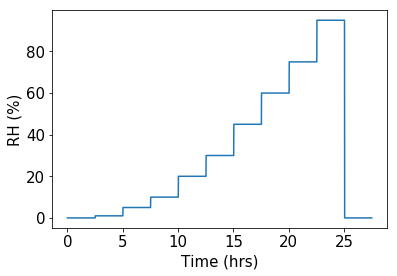

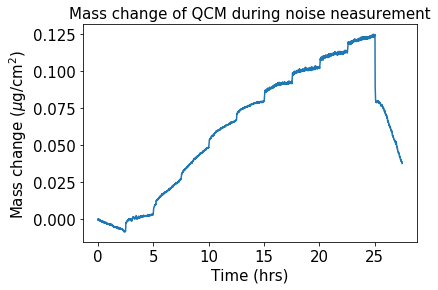

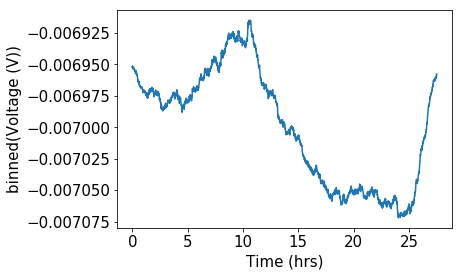

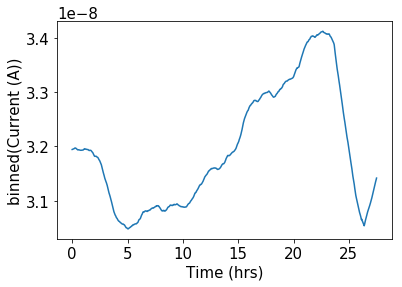

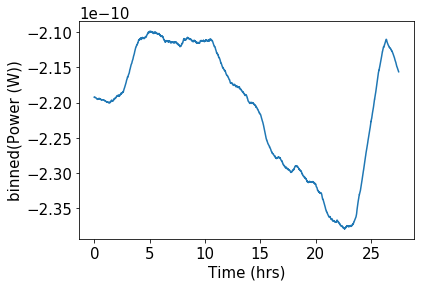

In [ ]:
#  MATCH UP NOISE DATA WITH PRESSURE DATA
from scipy import stats

ptime = np.array(pressuredata['elapsed_time_min'] - min(pressuredata['elapsed_time_min']))/60 #pressure times
rh = np.array(pressuredata['pressure_setpoint_Torr']) #pressures (or RH)

#compress each variable to length of pressure data by taking statistics of bins
tmatch = stats.binned_statistic(tlong, tlong, statistic='median', bins=len(ptime))[0] 
vmatch = stats.binned_statistic(tlong, vtfilt, statistic='median', bins=len(ptime))[0]
imatch = stats.binned_statistic(tlong, itfilt, statistic='median', bins=len(ptime))[0]
pmatch = stats.binned_statistic(tlong, ptfilt, statistic='median', bins=len(ptime))[0]

print('min/max noise times = ' + format(min(tlong)) + ' - ' + format(max(tlong)))
print('min/max pressure times = ' + format(min(ptime)) + ' - ' + format(max(ptime)))
print('min/max compressed noise times = ' + format(min(tmatch)) + ' - ' + format(max(tmatch)))
print('# of noise time points = ' + format(len(tlong)))
print('# of pressure time points = ' + format(len(ptime)) + '; # of compressed noise points = ' + format(len(tmatch)))

plt.plot(ptime,rh); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('RH (%)', fontsize=15);
plt.show() #plot pressure / RH

plt.plot(ptime, pressuredata.iloc[:,6]) #plot QCM response during noise measurement
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('Mass change ($\mu$g/cm$^2$)', fontsize=15)
plt.title('Mass change of QCM during noise neasurement', fontsize=15); plt.show()

plt.plot(ptime,vmatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Voltage (V))', fontsize=15); plt.show()
plt.plot(ptime,imatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Current (A))', fontsize=15); plt.show()
plt.plot(ptime,pmatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Power (W))', fontsize=15); plt.show()

In [ ]:
# USE NEURAL NET REGRESSOR TO PREDICT PRESSURE USING NOISE DATA

NNpnts = len(vmatch) #number of points to sample for ANN analysis
ptime_short = ptime[::int(len(vmatch)/NNpnts)] #slice to reduce number of data points
vmatch_short = vmatch[::int(len(vmatch)/NNpnts)] 
imatch_short = imatch[::int(len(imatch)/NNpnts)]
pmatch_short = pmatch[::int(len(pmatch)/NNpnts)]
rh_short = rh[::int(len(rh)/NNpnts)]

############## standardize data by subtracting mean and dividing by st. dev. ###########
vmatch_st = np.divide(np.subtract(vmatch_short,np.mean(vmatch_short)),np.std(vmatch_short))
imatch_st = np.divide(np.subtract(imatch_short,np.mean(imatch_short)),np.std(imatch_short))
pmatch_st = np.divide(np.subtract(pmatch_short,np.mean(pmatch_short)),np.std(pmatch_short))
rh_st = np.divide(np.subtract(rh_short,np.mean(rh_short)),np.std(rh_short))

inputlist = (vmatch_st, imatch_st)# insert data to be used as columns for input matrix
targetlist = (rh_st) #insert data to be used as columns for target matrix

#create input matrix and target matrix for feeding into ANN
inputmatrix = np.array(inputlist).T if len(np.shape(inputlist)) > 1 else np.array(inputlist) 
targetmatrix = np.array(targetlist).T if len(np.shape(targetlist)) > 1 else np.array(targetlist)
targetmatrix = targetmatrix.reshape(-1,1)

actual = np.array([]); prediction = np.array([]) #empty arrays for appending ANN results at each k-fold
errors_raw = np.array([]); tar_times = np.array([])

all_times = np.array([]); #create arrays to collect results from each learning rate
all_errors_raw = np.array([]); all_mse = np.array([])

learningrates = np.arange(0.005, 0.1, 0.0025) #original learning rate was 0.02 

for rate in range(len(learningrates)): #loop over learning rates
    
    mse = np.array([])
    
    NNstarttime = timer() #start timer to monitor training time
    
    nn = Regressor(layers=[
            Layer('Sigmoid', units=14), # design network with hidden layers
            Layer('Sigmoid', units=5),
            Layer('Sigmoid', units=2),
            Layer('Linear')], #output layer
        learning_rate=learningrates[rate], n_iter=1000)
    kf = KFold(n_splits=5, shuffle=True) # k-fold validation for ANN testing

    for train_index, test_index in kf.split(inputmatrix): #split into k test/train sets and loop oever each one
        inp_train, inp_test = inputmatrix[train_index], inputmatrix[test_index]
        tar_train, tar_test = targetmatrix[train_index], targetmatrix[test_index]

        nn.fit(inp_train, tar_train) #train network
        prediction_raw = nn.predict(inp_test) #make predictions (still standardized)

        prediction0 = np.add(np.multiply(np.std(rh_short),prediction_raw),np.mean(rh_short)) #unstandardize prediction
        actual0 = np.add(np.multiply(np.std(rh_short),tar_test),np.mean(rh_short)) #unstandardize actual target
        prediction = np.append(prediction, prediction0) #build predictions
        actual = np.append(actual, actual0) #build actual targets
        errors_raw = np.append(errors_raw, np.subtract(actual0, prediction0)) #calculate prediction errors
        tar_times = np.append(tar_times, ptime_short[test_index]) #make array of times that correspond to testing points

        #print(nn.get_parameters()) #summarize network parameters
        
        mse0 = mean_squared_error(actual, prediction)
        mse = np.append(mse, mse0)
        mse_mean = np.mean(mse)
        
    NNendtime = timer(); NNtime = (NNendtime - NNstarttime) / 60 #total training time in minutes
    print('learning rate = ', learningrates[rate])
    print('training time (min) = ', round(NNtime,3))
    print('avg. absolute residual (% RH) = ', round(np.mean(np.abs(errors_raw)),3))
    print('-----------------------------------------------')
    
    all_times = np.append(all_times, NNtime)
    all_errors_raw = np.append(all_errors_raw, np.mean(np.abs(errors_raw)))
    all_mse = np.append(all_mse, mse_mean)
'''
plt.plot(ptime_short, rh_short, c='b', linewidth=2, label='Actual RH') #plot pressure / RH
plt.scatter(tar_times, prediction, c='k', s=1, label='Predicted RH') #plot predictions
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('RH (%)', fontsize=15)
plt.legend(loc='upper left', fontsize=15); plt.show()

plt.scatter(tar_times, errors_raw, c='r', s=6) #plot errors
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('Residuals (% RH)', fontsize=15)
plt.show()
'''
    
plt.scatter(learningrates, all_times, c='k', s=6)
plt.xlabel('Learning rate', fontsize=15); plt.ylabel('Training time (min)', fontsize=15)
plt.show()
print('learning rates = ', learningrates, '\n training times (min) = ', all_times)

plt.scatter(learningrates, all_errors_raw, c='k', s=6)
plt.xlabel('Learning rate', fontsize=15); plt.ylabel('Avg. abs. residual (RH)', fontsize=15)
plt.show()
print('learning rates = ', learningrates, '\n avg. residuals (%RH) = ', np.around(all_errors_raw, decimals=2))

plt.scatter(learningrates, all_mse, c='k', s=6)
plt.xlabel('Learning rate', fontsize=15); plt.ylabel('MSE', fontsize=15)
plt.show()
print('learning rates = ', learningrates, '\n mse = ', np.around(all_mse, decimals=2))


ERROR (theano.gof.opt): Optimization failure due to: LocalOptGroup(use_c_ger,use_c_gemv)
ERROR (theano.gof.opt): node: Gemv{no_inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, sigmoid.0, InplaceDimShuffle{0}.0, TensorConstant{0.0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\configparser.py", line 1138, in _unify_values
    sectiondict = self._sections[section]
KeyError: 'blas'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\theano\configparser.py", line 168, in fetch_val_for_key
    return theano_cfg.get(section, option)
  File "C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\configparser.py", line 781, in get
    d = self._unify_values(section, vars)
  File "C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\configparser.py", line 114

learning rate =  0.005
training time (min) =  9.826
avg. absolute residual (% RH) =  3.875
-----------------------------------------------
learning rate =  0.0075
training time (min) =  9.887
avg. absolute residual (% RH) =  3.681
-----------------------------------------------
learning rate =  0.01
training time (min) =  7.966
avg. absolute residual (% RH) =  3.683
-----------------------------------------------
learning rate =  0.0125
training time (min) =  5.151
avg. absolute residual (% RH) =  3.729
-----------------------------------------------
learning rate =  0.015
training time (min) =  5.005
avg. absolute residual (% RH) =  3.727
-----------------------------------------------
learning rate =  0.0175
training time (min) =  11.591
avg. absolute residual (% RH) =  3.823
-----------------------------------------------
learning rate =  0.02
training time (min) =  6.367
avg. absolute residual (% RH) =  3.796
-----------------------------------------------
learning rate =  0.0225
t

In [ ]:
# Analyze ANN errors
rhvalues = np.unique(actual)
errormean, errorstd = np.array([]), np.array([])
for i in rhvalues: #look through each individual RH value
    error00 = np.array([])
    for j in range(len(errors_raw)): #collect errors at each RH to average them as a function of RH
        if i == actual[j]: error00 = np.append(error00, errors_raw[j]) 
    errormean = np.append(errormean, np.mean(np.abs(error00)))
    errorstd = np.append(errorstd, np.std(np.abs((error00))))

plt.errorbar(rhvalues, errormean, yerr=errorstd, fmt='o', c='r')
plt.plot(rhvalues, errormean, c='k')
plt.fill_between(rhvalues, 0, errormean+errorstd, facecolor='red', alpha=.1, interpolate=True)
plt.fill_between(rhvalues, 0, errormean, facecolor='red', alpha=.3, interpolate=True)


plt.xlabel('RH (%)', fontsize=15); plt.ylabel('Mean error + st. dev.', fontsize=15)
plt.title('Points = average error per RH value; Bars = st. dev. of error')
plt.show()

print('RH values = ', rhvalues)
print('avg errors = ', np.around(errormean, decimals=2))
print('error st. dev. = ', np.around(errorstd, decimals=2))

In [ ]:
%store errormean

In [ ]:
learningrates = np.arange(0.005, 0.1, 0.0025)
print(len(learningrates))
learningrates

# SAVE NN RESULTS TO CSV FILE

NNfile = "NNresults.csv"
saveNNdata = []; NNheaders = []; savetar = []

#see if input/target lists are multi-dimensional and reshape if necessary
#save test inputs:
if len(np.shape(inputlist)) > 1:
    for i in range(len(inputlist)):
        saveNNdata.append(zip(*inp_test)[i])
        NNheaders.append('test_input' + str(i+1))
else:
    saveNNdata.append(np.reshape(inp_test,len(inp_test)))
    NNheaders.append('test_input')
    
#save test targets and predictions:
if len(np.shape(targetlist)) > 1:
    for i in range(len(targetlist)):
        saveNNdata.append(zip(*tar_test)[i]) 
        NNheaders.append('test_target' + str(i+1))
        saveNNdata.append(zip(*prediction)[i])
        NNheaders.append('prediction' + str(i+1))
else:
    saveNNdata.append(np.reshape(tar_test,len(tar_test)))
    NNheaders.append('test_target')
    saveNNdata.append(np.reshape(prediction, len(tar_test)))
    NNheaders.append('prediction')
                        
saveNNdata = zip(*saveNNdata)
#open CSV file
with open(NNfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(NNheaders) #write headers
    for row in saveNNdata:
        writer.writerow(row)

#grid search optimizes network among the choices you give it:
'''
gs = GridSearchCV(nn, param_grid={
    'learning_rate': [0.05, 0.01, 0.005, 0.001],
    'hidden0__units': [4,8,12]
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''
# or among random parameters:
'''
gs = RandomizedSearchCV(nn, param_distributions={
    'learning_rate': stats.uniform[0.001, 0.1],
    'hidden0__units': stats.radint[3,15],
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''
#to save trained network:
#pickle.dump(nn, open('nn.pk1', 'wb'))

#to load trained network:
# nn = pickel.load(open('nn.pk1', 'rb'))

